# Transdimensional nonequilibrium free energy calculations for molecular design

### ADAPTIVE SAMPLING

### P. B. Grinway, H. E Bruce Macdonald, A. Rizzi, Z. Tan, J. M. Behr, I. Zhang, B. Allen, W. Sherman, J. D. Chodera

### FreeSolv dataset

Adaptively selecting atom mappings using a Normal-Normal inverse gamma Bayesian Bandit

Sampling free energies, which follow a normal distribuition of unknown $\mu$ and $\sigma$

Prior Normal inverse gamma F($\nu$=0,$\lambda$=1,$\alpha$=2,$\beta$=1), where $\nu$ is the mean.


Prioritizing sampling from atom mappings with the small variance.

In [1]:
from drugbandit import bandit, pull, choose
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import random
import itertools
from scipy.special import erf

import pandas as pd

import seaborn as sns
# from random import randint

%matplotlib inline

Loading the example ligands

In [2]:
ligands = []
# import drugbandit
lig_id = 0
with open('set_of_eight.smiles','r') as f:
    index = 0
    for line in f:
        if line[0] != '#':
            details = line.split(';')
            ligands.append(bandit.Node(details[2], float(details[3]), float(details[4]),lig_id))
            lig_id += 1

index = 0
edges = []

lig_ids = [lig.index for lig in ligands]


#TODO this currently initiates edges with 3 mappings of different deviations
for lig_a, lig_b in itertools.combinations(ligands,2):  # generating all edges
    edges.append(bandit.Edges(lig_a,lig_b))
    index+=1
    
# edges = [bandit.Edges(lig_a,lig_a)]

In [3]:
#########################
# simulation parameters #
#########################
steps_per_edge = 10000
print_freq = 5000
boltzmann_temp = 1.

### ADAPTIVE


#### TODO: increase preference for smaller variance
Sampling mapping inversely proportional to the bandit's standard deviation

Step 0


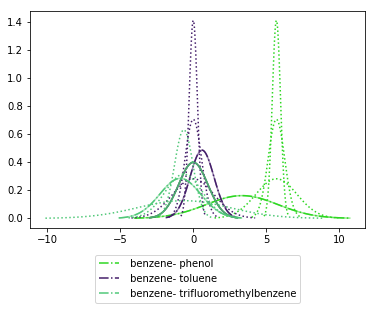

Step 5000


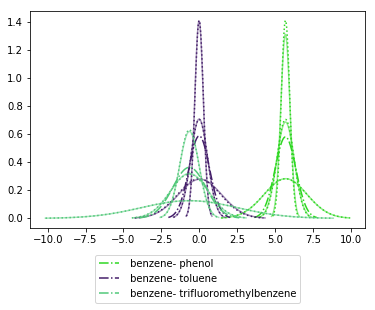

Step 10000


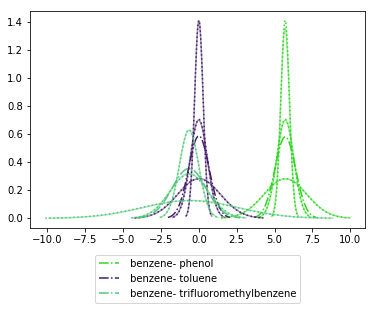

In [4]:
adaptive_errors = []
adaptive_counts = []

for step in range(0,steps_per_edge+1):
    for edge in edges:
        pick_bandit = choose.boltzmann_ranking(edge.bandits,boltzmann_temp)
        print
#         print('real',pick_bandit.name)
        reward = pull.Pull(pick_bandit)
        pick_bandit.update(reward)
        edge.update()
        
    if step % print_freq == 0:
        print('Step {}'.format(step))
        ax = plt.subplot(1, 1, 1)
        for edge in edges[0:3]: # only plotting a subset of bandits to see how they're doing
            edge.plot()
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
        plt.show()

adaptive_errors = []
adaptive_steps = []

for edge in edges:
    for band in edge.bandits:
        adaptive_errors.append(band.error)
        adaptive_steps.append(band.nsteps)

adaptive_sigma = [edge.sigma for edge in edges]


### VANILLA

Step 0


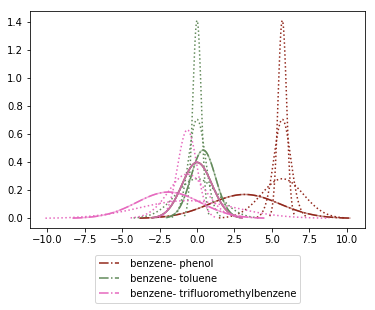

Step 5000


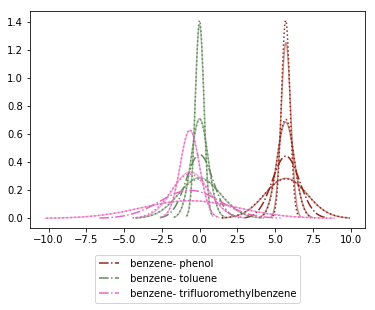

Step 10000


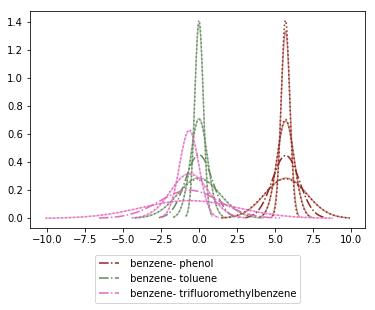

In [5]:
# resets the bandits
edges = []
for lig_a, lig_b in itertools.combinations(ligands,2): 
    edges.append(bandit.Edges(lig_a,lig_b))
    index+=1
    
for step in range(0,steps_per_edge+1):
    for edge in edges:
        pick_bandit = np.random.choice(edge.bandits) # mappings chosen at random
        reward = pull.Pull(pick_bandit)
        pick_bandit.update(reward)
        edge.update()
        
    if step % print_freq == 0:
        print('Step {}'.format(step))
        ax = plt.subplot(1, 1, 1)
        for edge in edges[0:3]:
            edge.plot()
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
        plt.show()

vanilla_errors = []
vanilla_steps = []

for edge in edges:
    for band in edge.bandits:
        vanilla_errors.append(band.error)
        vanilla_steps.append(band.nsteps)
vanilla_sigma = [edge.sigma for edge in edges]

/Users/brucemah/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


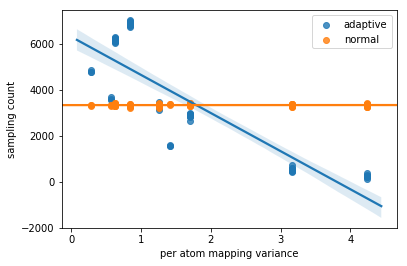

In [6]:
sns.regplot(x=adaptive_errors,y=adaptive_steps,label='adaptive')
sns.regplot(x=vanilla_errors,y=vanilla_steps,label='normal')
plt.xlabel('per atom mapping variance')
plt.ylabel('sampling count')
plt.legend()

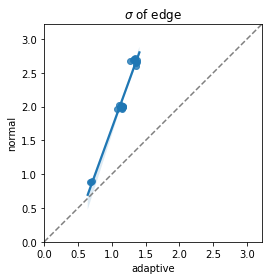

In [7]:
unity = [0,max(adaptive_sigma+vanilla_sigma)+0.5]
fig = plt.figure()
ax = fig.add_subplot(111,aspect=1)
# plt.
sns.regplot(x=adaptive_sigma,y=vanilla_sigma,label='normal')
plt.xlim(unity)
plt.ylim(unity)
plt.title('$\sigma$ of edge')
plt.xlabel('adaptive')
plt.ylabel('normal')
plt.plot(unity,unity,'--',color='grey')

### Mcl-1 dataset

Adaptively selecting atom mappings using a Bernoulli-Beta Bayesian Bandit

Sampling likelihood that lig X is higher affinity than reference

Prior Beta($\alpha$=1,$\beta$=1).

Prioritizing sampling of ligands with highest affinity.

Sampling atom-mappings with smaller variance. 

In [88]:
all_errors = pd.DataFrame(columns=['effort','Simulation type','map error / kcal mol$^{-1}$'])
all_bandits = pd.DataFrame(columns=['name','Simulation type','mu','error','steps'])
all_nodes = pd.DataFrame(columns=['name','exp','Simulation type','sim','steps'])

In [89]:
def load_ligands(base_id):
    # Loading the example ligands
    ligands = []
    # import drugbandit
    lig_id = 0
    with open('set_of_eight.smiles','r') as f:
        index = 0
        for line in f:
            if line[0] != '#':
                details = line.split(';')
                ligands.append(bandit.Node(details[2], float(details[3]), float(details[4]),lig_id))
                lig_id += 1
    
    edges = []

    #TODO this currently initiates edges with 3 mappings of different deviations
    for lig_a, lig_b in itertools.combinations(ligands,2):  # generating all edges
        edges.append(bandit.Edges(lig_a,lig_b))
        index+=1

    n_steps = 1 # include paths between ligands that involve up to n_steps edges

    for ligand in ligands:
        ligand.find_all_paths(base_id,edges,n_steps)
    return edges, ligands

In [90]:
#########################
# simulation parameters #
#########################
steps_per_edge = 10 # think this should be half of the samples available
print_freq = 1
boltzmann_temp = 1. # larger value = more random
repeats = 3 
baseline_ligand = 0
#TODO repeats = 10, with different benchmark ligand each time... 

In [91]:
sim='regular'

for _ in range(0,repeats):

    edges, ligands = load_ligands(baseline_ligand)
    steps_per_lig = [0. for _ in ligands]
    steps = steps_per_edge*len(ligands)

    colours = sns.cubehelix_palette(steps+1)
    colours = sns.color_palette("RdBu_r", steps+1)

    alpha = []
    beta = []

    vanilla_error = []
    # testing each atom mapping once as a starting point
    for edge in edges:
        for band in edge.bandits:
            reward = pull.Pull(band)
            band.update(reward)
    total_steps = 0
    lig_ids = [ligand.index for ligand in ligands]
    # edges = [ligand]
    for step in range(0,steps_per_edge+1):
        for edge in edges:
            for band in edge.bandits:
                reward = pull.Pull(band)
                band.update(reward)
                edge.update()
                for lig_id in edge.indexes:
                    reward = ligands[lig_id].pull(edges)
                    ligands[lig_id].update(reward)
                    steps_per_lig[lig_id] += 1
                total_steps += 1

        if step % print_freq == 0:    
            map_error = np.mean([edge.sigma for edge in edges])
            all_errors = all_errors.append({'effort':total_steps,'Simulation type':sim,'map error':map_error},ignore_index=True)

        vanilla_error.append(np.mean([edge.sigma for edge in edges]))
    for edge in edges:
        for band in edge.bandits:
            all_bandits = all_bandits.append({'name':band.name,'Simulation type':sim,'mu':edge.mu,'error':band.sigma,'steps':band.nsteps},ignore_index=True)

    for j,lig in zip(steps_per_lig,ligands):
        all_nodes = all_nodes.append({'name':lig.name,'exp':lig.fe-ligands[baseline_ligand].fe,'mu':-lig.mu,'Simulation type':sim,'steps':j},ignore_index=True)
        

In [94]:
sim = 'adaptive'
for rep in range(0,repeats):
    edges, ligands = load_ligands(baseline_ligand)
    steps_per_lig = [0. for _ in ligands]
    
#     steps = steps_per_ligand*len(ligands)
    colours = sns.cubehelix_palette(steps+1)
    colours = sns.color_palette("RdBu_r", steps+1)

    alpha = []
    beta = []

    adaptive_error = []
    # testing each atom mapping once as a starting point
    for edge in edges:
        for band in edge.bandits:
            reward = pull.Pull(band)
            band.update(reward)

    lig_ids = [ligand.index for ligand in ligands]
    for step in range(0,total_steps+1):
        pick_ligand = choose.boltzmann(ligands,boltzmann_temp)
        pick_edge = np.random.choice([edge for edge in edges if pick_ligand.index in edge.indexes])
        pick_bandit = choose.boltzmann_ranking(pick_edge.bandits,boltzmann_temp)
        reward = pull.Pull(pick_bandit)    
        map_reward = pull.Pull(pick_bandit)
        pick_bandit.update(map_reward)

        pick_edge.update()
        for lig_id in pick_edge.indexes:
            reward = ligands[lig_id].pull(edges)
            ligands[lig_id].update(reward)        
            steps_per_lig[lig_id] += 1

        if step % print_freq == 0:    
#             alpha.append(ligands[0].a)
#             beta.append(ligands[0].b)
#             ligands[0].plot_bandit(colours[step])
            map_error = np.mean([edge.sigma for edge in edges])
            all_errors = all_errors.append({'effort':step,'Simulation type':sim,
                                            'map error':map_error},ignore_index=True)
    
    for edge in edges:
        for band in edge.bandits:
            all_bandits = all_bandits.append({'name':band.name,'Simulation type':sim,'mu':edge.mu,
                                              'error':band.sigma,'steps':band.nsteps}
                                             ,ignore_index=True)
    
    for j,lig in zip(steps_per_lig,ligands):
        all_nodes = all_nodes.append({'name':lig.name,'exp':lig.fe-ligands[baseline_ligand].fe,'mu':-lig.mu,'Simulation type':sim,'steps':j},ignore_index=True)



/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [95]:
# x = []
# y = []
# for edge in edges:
#     for band in edge.bandits:
#         x.append(band.sigma)
#         y.append(band.nsteps)
# sns.scatterplot(x,y)
# plt.xlabel('standard deviation of atom mapping')
# plt.ylabel('number of steps')


In [96]:
#### PLOTS FE's of the ligands depending on PATH

# for x in ligands:
#     print(x.fe)
#     print('mean',(x.a)/(x.a+x.b))
#     x.plot_bandit()
#     plt.xlabel('probability that {} is better than reference molecule'.format(x.name))
#     plt.show()
#     x.plot_node(edges)
#     plt.legend()
#     plt.show()

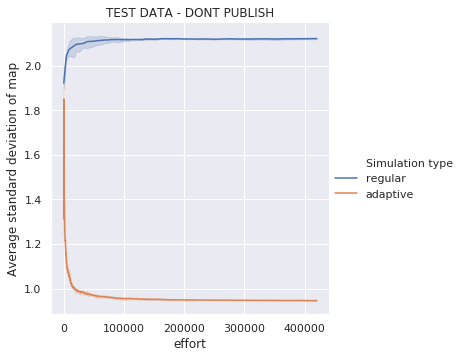

In [12]:
sns.set(style="darkgrid")
sns.relplot(x='effort',y='map error', kind='line', data = all_errors,hue='Simulation type')
plt.ylabel('Average standard deviation of map')
plt.title('TEST DATA - DONT PUBLISH')

AttributeError: 'NoneType' object has no attribute 'remove'

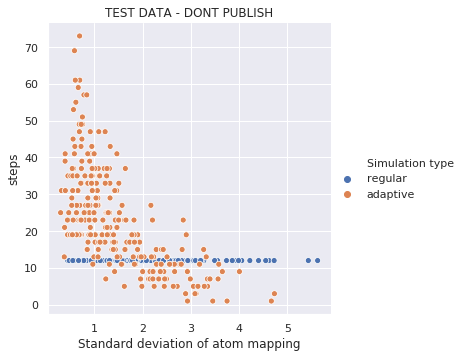

In [135]:
# print(all_bandits)
sns.relplot(x='error',y='steps',hue='Simulation type',data=all_bandits)
plt.xlabel('Standard deviation of atom mapping')
plt.title('TEST DATA - DONT PUBLISH')


Text(0.5, 1.0, 'TEST DATA - DONT PUBLISH')

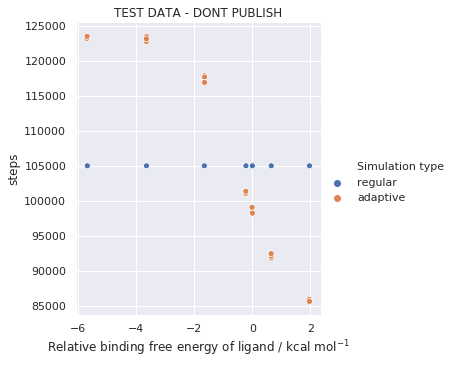

In [14]:
sns.relplot(x='mu',y='steps',hue='Simulation type',data=all_nodes)
plt.xlabel('Relative binding free energy of ligand / kcal mol$^{-1}$')
plt.title('TEST DATA - DONT PUBLISH')

Text(0, 0.5, 'Calculated / kcal mol $^{-1}$')

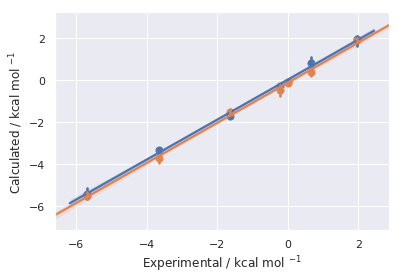

In [137]:
# plt.plot([-7,3],[-7,3],color='white')
sns.regplot(x='exp',y='mu',data=all_nodes[all_nodes['Simulation type'].isin(['regular'])],x_estimator=np.mean)
sns.regplot(x='exp',y='mu',data=all_nodes[all_nodes['Simulation type'].isin(['adaptive'])],x_estimator=np.mean)
plt.xlabel('Experimental / kcal mol $^{-1}$')
# TODO make this plot square
plt.ylabel('Calculated / kcal mol $^{-1}$')